Emupy 1D Example
====
Duncan Rocha, Nick Kern
12/1/2020

In this example we use emupy to tackle a very simple toy problem. We have two underlying functions of $x$, $f$ and $g$, from which we make noisy data. The objective is to use emupy to set up a prediction function for the noisy data that accurately describes the underlying functions.

In [1]:
# Import modules
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
from emupy.gpr import GPEmulator
from emupy.linear import LinearEmulator
import sklearn.gaussian_process as gp
import scipy.stats as stats
import time
import copy

Text(0, 0.5, '$g$ Data')

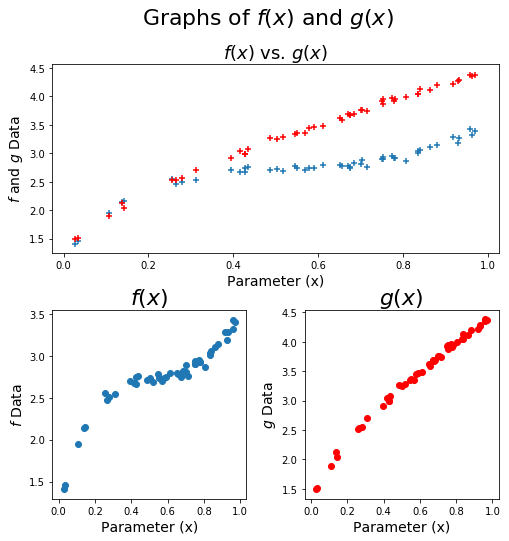

In [2]:
# Format of setting up data:
# Choose how many points between 0 and 1
n = 100

# Create linspace array
all_x = np.random.uniform(0,1,n)

# Specify functions
# defaults:  
# f(x) = sqrt(x) + sin(x)/4
# g(x) = 
f = lambda x: np.sqrt(6*x) + 1 + np.sin(x*np.pi*2)/4 + np.random.normal(0,.04,n)
g = lambda x: np.sqrt(6*x) + x + 1 + np.random.normal(0,.04,n)

# Create data array
fx = f(all_x)
gx = g(all_x)
all_data = np.array([fx,gx]).T

# Choose half of it to train the gaussian, half of it for cross validation at the end
indices = np.arange(0,n,1)
rand = np.random.choice(indices,n//2,replace=False)
select = np.zeros(n,dtype='bool')
select[rand] = True
x_train = all_x[select]
data = all_data[select]
x_cv = all_x[~select]
data_cv = all_data[~select]

# Pick out f(x) and g(x) for graphing
fx = data.T[0]
gx = data.T[1]

# Create matplotlib figure to display data
fig1 = plt.figure(figsize=(8,8))
fig1.suptitle('Graphs of $f(x)$ and $g(x)$',fontsize=22)
fig1.subplots_adjust(wspace=0.3,hspace=0.3)

# Plot f and g data together
ax1 = fig1.add_subplot(211)
ax1.scatter(x_train,fx,marker='+')
ax1.scatter(x_train,gx,c='r',marker='+')
ax1.set_title('$f(x)$ vs. $g(x)$',fontsize='18')
ax1.set_xlabel('Parameter (x)',fontsize=14)
ax1.set_ylabel('$f$ and $g$ Data',fontsize=14)

# Plot only f(x)
ax2 = fig1.add_subplot(223)
ax2.scatter(x_train,fx)
ax2.set_title('$f(x)$',fontsize=22)
ax2.set_xlabel('Parameter (x)',fontsize=14)
ax2.set_ylabel('$f$ Data',fontsize=14)

# Plot only g(x)
axe3 = fig1.add_subplot(224)
axe3.scatter(x_train,gx,c='r')
axe3.set_title('$g(x)$',fontsize=22)
axe3.set_xlabel('Parameter (x)',fontsize=14)
axe3.set_ylabel('$g$ Data',fontsize=14)

## 1. GPEmulator

In [3]:
# instantiate Gaussian Process Emulator
E = GPEmulator()

In [4]:
# Sphere the training data features to a centered and whitened basis
Xsph = E.sphere(x_train[:, None], save=True)

In [5]:
# scale the ydata: notice above that both f and g are not mean-zero over the observed x range
# this can make it harder for the GP to get accurate and robust results
# so we will emulate the mean-subtracted and variance whitened data
data_scaled = E.scale_data(data, whiten=False, save=True)

In [6]:
## Setup GP kernel for fitting
# RBF kernel plus white noise kernel for numerical stability
kernel = gp.kernels.RBF() + gp.kernels.WhiteKernel()
GP = gp.GaussianProcessRegressor(kernel=kernel, n_restarts_optimizer=10)

In [7]:
# train GP emulator
E.train(Xsph, data_scaled, GP)

In [8]:
# setup new prediction coordinates
nnew = 100
pred_coords = np.linspace(-0.2, 1.2, nnew)[:, None]

# sphere coords
pred_sph = E.sphere(pred_coords, Xmean=E.Xmean, L=E.L, save=False)

# Run through E.predict
pred_output, error = E.predict(pred_sph, return_std=True, unscale=True)

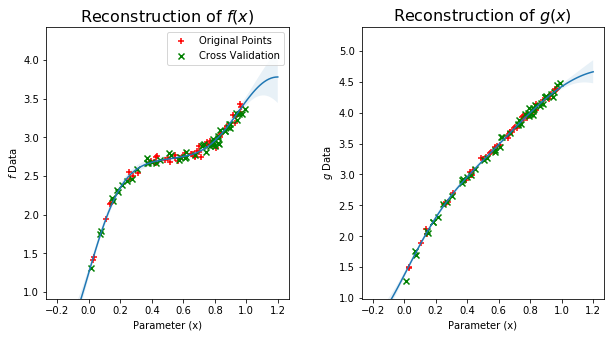

In [9]:
fig2 = plt.figure(figsize=(10,5))
fig2.subplots_adjust(wspace=0.3)

# Plot 1: prediction of f(x) against the original f(x) data (red) and cross validation (green)
ax3 = fig2.add_subplot(121)
ax3.plot(pred_coords[:, 0],pred_output[:, 0])
ax3.fill_between(pred_coords[:, 0],(pred_output-error)[:, 0],(pred_output+error)[:, 0],alpha=0.1)
orig = ax3.scatter(x_train,fx,color='r',marker='+')
cv = ax3.scatter(x_cv,data_cv[:, 0],color = 'g', marker='x')
ax3.set_title('Reconstruction of $f(x)$',fontsize=16)
ax3.set_xlabel('Parameter (x)')
ax3.set_ylabel('$f$ Data')
ax3.set_ylim(np.min(fx)-0.5,np.max(fx)+1)

# Plot 2: prediction of g(x) against the original g(x) data (red) and cross validation data (green)
ax4 = fig2.add_subplot(122)
ax4.plot(pred_coords[:, 0],pred_output[:, 1])
ax4.scatter(x_train,gx,color = 'r', marker='+')
ax4.fill_between(pred_coords[:, 0],(pred_output-error)[:, 1],(pred_output+error)[:, 1],alpha=0.1)
ax4.scatter(x_cv,data_cv[:, 1],color = 'g', marker='x')
ax4.set_title('Reconstruction of $g(x)$', fontsize=16)
ax4.set_xlabel('Parameter (x)')
ax4.set_ylabel('$g$ Data')
ax4.set_ylim(np.min(gx)-0.5,np.max(gx)+1)

ax3.legend([orig, cv], ["Original Points", "Cross Validation"])

## 2. LinearEmulator

In [10]:
# instantiate linear emulator
L = LinearEmulator()

In [11]:
# Sphere the training data features to a centered and whitened basis
Xsph = L.sphere(x_train[:, None], save=True)

In [12]:
# train polynomial emulator
degree = 5
basis = 'direct' # try also: 'legendre'
L.train(Xsph, data, degree, basis=basis)

In [13]:
# setup new prediction coordinates
nnew = 100
pred_coords = np.linspace(-0.2, 1.2, nnew)[:, None]

# sphere coords
pred_sph = L.sphere(pred_coords, Xmean=L.Xmean, L=L.L, save=False)

pred_output = L.predict(pred_sph)

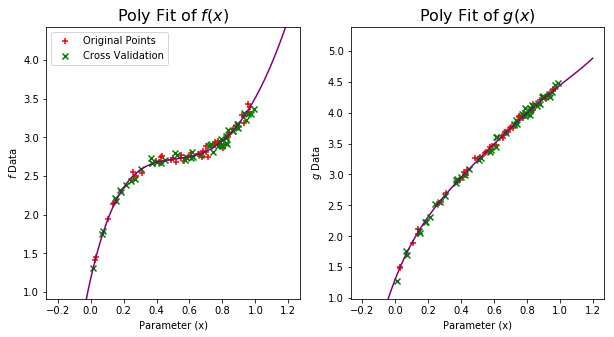

In [14]:
fig3 = plt.figure(figsize=(10,5))

# Plot 1: prediction of f(x) against the original f(x) data (red) and cross validation (green)
ax5 = fig3.add_subplot(121)
ax5.plot(pred_coords[:,0],pred_output[:,0],color='purple')
orig = ax5.scatter(x_train,fx,color='r',marker='+')
cv = ax5.scatter(x_cv,data_cv.T[0],color = 'g', marker='x')
ax5.set_title('Poly Fit of $f(x)$',fontsize=16)
ax5.set_xlabel('Parameter (x)')
ax5.set_ylabel('$f$ Data')
ax5.set_ylim(np.min(fx)-0.5,np.max(fx)+1)

# Plot 2: prediction of g(x) against the original g(x) data (red) and cross validation data (green)
ax6 = fig3.add_subplot(122)
ax6.plot(pred_coords[:,0],pred_output[:,1],c='purple')
ax6.scatter(x_train,gx,color = 'r', marker='+')
ax6.scatter(x_cv,data_cv.T[1],color = 'g', marker='x')
ax6.set_title('Poly Fit of $g(x)$', fontsize=16)
ax6.set_xlabel('Parameter (x)')
ax6.set_ylabel('$g$ Data')
ax6.set_ylim(np.min(gx)-0.5,np.max(gx)+1)

ax5.legend([orig, cv], ["Original Points", "Cross Validation"])

(-0.15, 0.15)

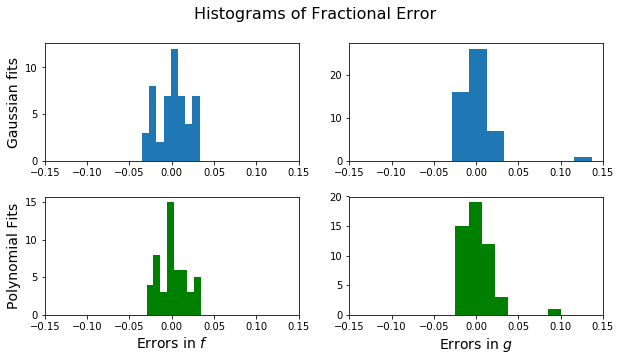

In [15]:
# Now for some statistical cross validation. First, we will use cross_validate to generate
# predictions for g and f for every x value in x_cv. Remember that we have to turn the array x_cv
# into a matrix x_cvm in order to pass it through emupy.

# Create histogram axes
fig4 = plt.figure(figsize=(10,5))
fig4.suptitle('Histograms of Fractional Error',fontsize='16')
fig4.subplots_adjust(wspace=0.2,hspace=0.3)
hist1 = fig4.add_subplot(221)
hist2 = fig4.add_subplot(222)
hist3 = fig4.add_subplot(223)
hist4 = fig4.add_subplot(224)

# Get GP and Linear predictions at distinct cross-validation data points
gp_pred_cv = E.predict(E.sphere(x_cv[:, None], Xmean=E.Xmean, L=E.L, save=False))
gp_pred_cv = E.unscale_data(gp_pred_cv)
lin_pred_cv = L.predict(L.sphere(x_cv[:, None], Xmean=L.Xmean, L=L.L, save=False))

# Take the fractional error from the cross validation output in E.recon_cv
frac_err = (gp_pred_cv - data_cv) / data_cv
poly_frac_err = (lin_pred_cv - data_cv) / data_cv

# Plot the data into histograms
hist1.hist(frac_err.T[0],bins=8)
hist1.set_ylabel('Gaussian fits',fontsize=14)
hist1.set_xlim(-0.15,0.15)

hist2.hist(frac_err.T[1],bins=8)
hist2.set_xlim(-0.15,0.15)

hist3.hist(poly_frac_err.T[0],bins=8,color='g')
hist3.set_ylabel('Polynomial Fits',fontsize=14)
hist3.set_xlabel('Errors in $f$',fontsize=14)
hist3.set_xlim(-0.15,0.15)

hist4.hist(poly_frac_err.T[1],bins=8,color='g')
hist4.set_xlabel('Errors in $g$',fontsize=14)
hist4.set_xlim(-0.15,0.15)

# For the plots below, the top two are the fractional error of the gaussian cross validation of f and g respectively, 
# and the bottom two the fractional errors from the polynomial cross validation